### Dự đoán giá nhà trên Kaggle
#### 1. Tải và lưu trữ bộ dữ liệu
- Ta sẽ cần tải và thử nghiệm nhiều mô hình trên các tập dữ liệu khác nhau. Ta sẽ lập trình một số hàm tiện ích để hỗ trợ cho việc tải dữ liệu. 
- Đầu tiên ta cần tạp một từ điển DATA_HUB nhằm ánh xạ một xâu ký tự đến đường dẫn (URL) với SHA-1 của tệp tại đường dẫn đó, trong đó SHA-1 dùng để xác minh tính toàn vẹn của tệp. Các tập dữ liệu này được lưu trữ trên trang DATA_URL.

In [166]:
import os
from mxnet import gluon
from d2l import mxnet as d2l
import zipfile
import tarfile

DATA_HUB = dict()

DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

- Hàm dowload dưới đây tải tập dữ liệu có tên name từ đường dẫn tương ứng và lưu nó tại bộ nhớ cục bộ (mặc định tại ../data). Nếu tệp trên đã tồn tại trong bộ nhớ đệm và SHA-1 của nó khớp với tệp trong DATA_HUB, tệp trong bộ nhớ sẽ được sử dụng luôn mà không cần tải lại.
- Điều này nghĩa là ta chỉ cần tải tập dữ liệu đúng một lần khi có kết nối mạng. Hàm dowload trả về tên của tệp được tải xuống.

In [167]:
def dowload(name, cahe_dir = '../data'):
    """Dowload a file inserted into DATA_HUB, return the local file name"""
    assert name in DATA_HUB, "%s doesn't exist" % name
    url, sha1 = DATA_HUB[name]
    # d2l.mkdir_if_not_exist(cahe_dir)
    return gluon.utils.download(url, cahe_dir, sha1_hash = sha1)


- Ta cần lập trình thêm hai hàm khác, một hàm để tải và giải nén tệp zip/tar và hàm còn lại để tải tất cả các file từ DATA_HUB về bộ nhớ đệm. 

In [168]:
def dowload_extract(name, folder = None):
    """Dowload nd extract a zip/tar file"""
    fname = dowload(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)

    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext == '.tar' or ext == '.gz':
        fp = tarfile.open(fname, 'r')
    else:
        assert False, "Only zip/tar files can be extracted"
    
    fp.extractall(base_dir)
    if folder:
        return base_dir + '/' + folder + '/'
    else:
        return data_dir + '/'
def dowload_all():
    for name in DATA_HUB:
        dowload(name)

#### 2. Truy cập và đọc bộ dữ liệu
- Lưu ý rằng dữ liệu của cuộc thi được tách thành tập huấn luyện và tập kiểm tra. Mỗi tập dữ liệu bao gồm giá tiền của ngôi nhà và các thuộc tính liên quan bao gồm loại đường phố, năm xây dựng, ...
- Các đặc trưng được biểu diễn bởi nhiều kiểu dữ liệu. Ví dụ, năm xây dựng được biểu diễn bởi số nguyên, kiểu mái nhà là đặc trưng hạng mục rời rạc còn các đặc trưng khác thì được biểu diễn bởi số thực dấu phẩy động.
- Đây là khi ta đối mặt với vấn đề thực tiễn, mở một vài mẫu dữ liệu bị thiếu và được đơn thuần chú thích là 'na'.

In [169]:
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd
npx.set_np()

- Để thuận tiện, ta sẽ tải và lưu tập dữ liệu giá nhà Kaggle từ trang web DATA_URL. Với những cuộc thi Kaggle khác, có thể ta sẽ phải tải dữ liệu về theo cách thủ công.

In [170]:
# Saved in the d2l package for later use
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

# Saved in the d2l package for later use
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [171]:
train_data = pd.read_csv(dowload('kaggle_house_train'))
test_data = pd.read_csv(dowload('kaggle_house_test'))

- Tập huấn luyện chứa 1460 mẫu, 80 đặc trưng và 1 nhãn. Tập kiểm tra chứa 1459 mẫu và 80 đặc trưng.

In [172]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


- Hãy cùng xem xét 4 đặc trưng đầu tiên, 2 đặc trưng cuối cùng và nhãn của 10 mẫu đầu tiên.

In [173]:
print(train_data.iloc[0:10, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
4   5          60       RL         84.0       WD        Normal     250000
5   6          50       RL         85.0       WD        Normal     143000
6   7          20       RL         75.0       WD        Normal     307000
7   8          60       RL          NaN       WD        Normal     200000
8   9          50       RM         51.0       WD       Abnorml     129900
9  10         190       RL         50.0       WD        Normal     118000


- Có thể thấy với mỗi mẫu, đặc trưng đầu tiên là ID. Điều này giúp mô hình xác định được từng mẫu. Mặc dù việc này khá thuận tiện nhưng nó không mang bất kỳ thông tin nào cho mục đích dự đoán. Do đó chúng ta sẽ lược bỏ nó ra khỏi tập dữ liệu trước khi đưa vào mạng nơ ron.

In [174]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.iloc[0:10, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml
4          60       RL         84.0    14260    2008       WD        Normal
5          50       RL         85.0    14115    2009       WD        Normal
6          20       RL         75.0    10084    2007       WD        Normal
7          60       RL          NaN    10382    2009       WD        Normal
8          50       RM         51.0     6120    2008       WD       Abnorml
9         190       RL         50.0     7420    2008       WD        Normal


#### 3. Tiền xử lý dữ liệu
- Trước khi đưa dữ liệu vào mạng học sâu, ta cần thực hiện một số phép xử lý. Bắt đầu với các đặc trưng số học. Trước hết ta thay thế các giá trị còn thiếu bằng giá trị trung bình. Đây là chiến lược hợp lý nếu các đặc trưng bị thiếu một cách ngẫu nhiên. Để đưa tất cả các đặc trưng số học về cùng một khoảng giá trị, ta thực hiện để chúng có trung bình bằng không và phương sai bằng cách:

    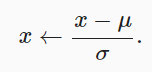

- Để kiểm tra xem công thức trên có chuyển đổi x thành dữ liệu với trung bình bằng 0 hay không thì ta có thể tính:
    + E[(x - nguy)/sigma] = (nguy - nguy)/sigma = 0
- Với phương sai:
    + E[(x - nguy)^2] = sigma ^ 2
- Như vậy biến chuyển đổi sẽ có phương sai đơn vị.

- Lý do của việc chuẩn hóa dữ liệu là do ta KHÔNG THỂ BIẾT TRƯỚC ĐẶC TRƯNG NÀO LÀ ĐẶC TRƯNG QUAN TRỌNG.

In [175]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print(numeric_features)

all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features.iloc[0:10, [0, 1, 2, 3, -3, -2, -1]])


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
   MSSubClass MSZoning  LotFrontage   LotArea    YrSold SaleType SaleCondition
0    0.067320       RL    -0.184443 -0.217841  0.157619       WD        Normal
1   -0.873466       RL     0.458096 -0.072032 -0.602858       WD        Normal
2    0.067320       RL    -0.055935  0.137173  0.157619       WD        Normal
3    0.302516       RL    -0.398622 -0.078371 -1.363335       WD       Abnorml
4    0.067320       RL    

- Tiếp theo ta sẽ xử lý các giá trị rời rạc như biến MSZoning. Ta sẽ thay thế chúng bằng biểu diễn one-hit theo đúng cách ta đã chuyển đổi dữ liệu phân loại đa lớp thành vector chứa 0 và 1. 
- Ví dụ, MSZoning bao gồm các giá trị RL và RM tương ứng lần lượt với vector (1, 0) và (0, 1). Việc này được thực hiện tự động trong pandas

In [176]:
# Dummy_na = True refers to a missing values being a legal eigenvalues and 
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)
print(all_features.iloc[0:10, [0, -3, -2, -1]])

(2919, 331)
   MSSubClass  SaleCondition_Normal  SaleCondition_Partial  SaleCondition_nan
0    0.067320                     1                      0                  0
1   -0.873466                     1                      0                  0
2    0.067320                     1                      0                  0
3    0.302516                     0                      0                  0
4    0.067320                     1                      0                  0
5   -0.167877                     1                      0                  0
6   -0.873466                     1                      0                  0
7    0.067320                     1                      0                  0
8   -0.167877                     0                      0                  0
9    3.124875                     1                      0                  0


- Cuối cùng, thông qua thuộc tính values, ta có thể trích xuất định dạng Numpy từ khung dữ liệu Pandas và chuyển đổi nó thành biểu diễn ndarray gốc của MNXet dành cho mục đích huấn luyện.

In [177]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype = np.float32)
test_features = np.array(all_features[n_train:].values, dtype = np.float32)
train_labels = np.array(train_data.SalePrice.values, dtype = np.float32).reshape(-1, 1)

train_features[:4], train_labels[:4]


(array([[ 0.06731988, -0.18444261, -0.21784137, ...,  1.        ,
          0.        ,  0.        ],
        [-0.8734664 ,  0.45809588, -0.07203174, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.06731988, -0.05593492,  0.13717337, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.30251643, -0.39862213, -0.07837129, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[208500.],
        [181500.],
        [223500.],
        [140000.]]))

#### 4. Huấn luyện
- Ta sẽ huấn luyện một mô hình tuyến tính với hàm mất mát bình phương. Tuy mô hình này đơn giản và có thể không đạt chính xác cao nhưng nó vẫn cho ta một phép kiểm tra sơ bộ để xem dữ liệu có chứa thông tin có ý nghĩa không. 
- Nếu mô hình này không thể đạt chất lượng tốt hơn việc đoán mò thì khả năng cao ta đang có lỗi trong quá trình xử lý dữ liệu.
- Nếu mô hình hoạt động thì đây sẽ đóng vai trò như giải pháp nền, giúp ta hình dung được khoảng cách giữa một mô hình đơn giản và các mô hình tốt nhất hiện có, cũng như mức độ cải thiện mà ta mong muốn từ các mô hình tốt hơn.

In [178]:
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

- Với giá nhà hay giá cổ phiếu, ta quan tâm đến các đại lượng tương đối hơn là tuyệt đối. Cụ thể hơn, ta thường quan tâm đến lỗi tương đổi (y - y_hat)/y hơn lỗi tuyệt đối y - y_hat. 
- Ví dụ, nếu ta dự đoán một ngôi nhà ở Rural Ohio bị lệch đi 100,000 đô la mà giá thông thường ở đó là 125000 đô la thì mô hình rất tệ. Nhưng nếu cùng độ lệch khi dự đoán nhà ở nơi có giá trung bình 4 triệu đô thì có thể lại là rất chính xác.
- Một cách để giải quyết vấn đề này là tính hiệu của log giá trị dự đoán và log giá trị thật sự.

    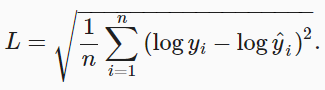


In [179]:
def log_rmse(net, features, labels):
    # Những giá trị < 1 thì chuyển thành 1
    clipped_pred = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_pred), np.log(labels)).mean())

- Khác với các mục trước, hàm huấn luyện ở đây sử dụng bộ tối ưu adam. Lợi thế chính của Adam so với SGD là nó không quá nhạy cảm với tốc độ học ban đầu, mặc dù kết quả cũng không tốt hơn SGD nếu tài nguyên để tối ưu siêu tham số là vô tận.

In [180]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)

    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay
    })

    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### 5. Kiểm định gập chéo K lần
- Ta sẽ ứng dụng kỹ thuật này để lựa chọn thiết kế mô hình và điều chỉnh các siêu tham số. Trước tiên ta cần một hàm trả về phần tử thứ i của dữ liệu trong kiếm định gập gập chép k-lần.
- Việc này được thực hiện bằng cách slicing phần tử thứ i để làm dữ liệu kiểm định và dùng phần còn lại làm dữ liệu huấn luyện. 

In [181]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k

    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]

        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else :
            X_train = np.concatenate((X_train, X_part), axis = 0)
            y_train = np.concatenate((y_train, y_part), axis = 0)
    return X_train, y_train, X_valid, y_valid

- Trong kiểm định chéo gập k-lần ta sẽ huấn luyện mô hình k lần và trả về trung bình lỗi huấn luyện và trung bình lỗi kiểm định.

In [182]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], 
                     xlabel = 'epoch', ylabel = 'rmse', legend = ['train', 'valid'],
                     yscale='log')
        
        print(f"fold {i}, train rmse: {train_ls[-1]}, valid rmse: {valid_ls[-1]}")

    return train_l_sum / k, valid_l_sum / k

#### 6. Lựa chọn mô hình
- Ta chọn ra một bộ siêu tham số, và ta sẽ cần phải dành thời gian cải thiện mô hình. Nếu được sử dụng đúng cách thì phương pháp kiểm định gập chéo k - lần sẽ có tính ổn định cao khi thực hiện với nhiều thử nghiệm.
- Tuy nhiên, nếu thử quá nhiều các lựa chọn siêu tham số thì phương pháp này có thể thất bại vì ta có thể chỉ đơn thuần gặp may ở một cách chia tập kiểm định phù hợp với bộ siêu tham số đó.
- Đôi khi lỗi huấn luyện cho một bộ siêu tham số có thể rất thấp trong khi lỗi của kiểm định k - fold có thể cao hơn. Đây là dấu hiệu của sự quá khớp. Vì vậy, khi ta giảm lỗi huấn luyện ta cũng cần kiểm tra xem liệu lỗi kiểm định chéo gập k lần có giảm tương ứng hay không.

fold 0, train rmse: 0.14398271, valid rmse: 0.14566961
fold 1, train rmse: 0.14099093, valid rmse: 0.15576613
fold 2, train rmse: 0.13879555, valid rmse: 0.14507513
fold 3, train rmse: 0.14413327, valid rmse: 0.14401081
fold 4, train rmse: 0.13783793, valid rmse: 0.17231117
5- fold validation: average train rmse: 0.14114808, avg valid rmse: 0.15256658


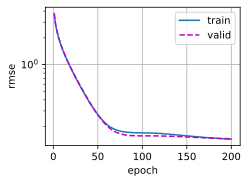

In [183]:
k, num_epochs, lr, weight_decay, batch_size = 5, 200, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f"{k}- fold validation: average train rmse: {train_l}, avg valid rmse: {valid_l}")

#### 7. Dự đoán và nộp bài
- Bây giờ, khi ta đã biết được lựa chọn tốt cho các siêu tham số, ta có thể sử dụng toàn bộ dữ liệu cho việc huấn luyện (thay vì chỉ dùng 1 - 1/k của dữ liệu như trong quá trình kiểm định chéo). Sau đó, ta áp dụng mô hình thu được lên tập kiểm tra và lưu các dự đoàn vào một tệp CSV nhằm đơn giản hóa quá trình tải kết quả lên Kaggle.

train_rmse: 0.13631573
[[113967.984]
 [158315.27 ]
 [187226.4  ]
 ...
 [194477.22 ]
 [108535.125]
 [238749.11 ]]


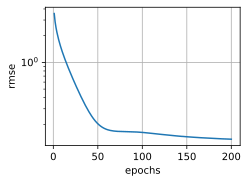

In [184]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                        num_epochs, lr, weight_decay, batch_size)
    
    d2l.plot(list(range(1, num_epochs + 1)), [train_ls], xlabel= "epochs",
             ylabel='rmse', yscale = 'log')
    
    print(f"train_rmse: {train_ls[-1]}")

    # Apply the netword to the test set
    preds = net(test_features).asnumpy()
    print(preds)
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return net

net = train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, 
               lr, weight_decay, batch_size)


In [185]:
preds = net(test_features)
print(preds, type(preds), preds.shape)
print(preds.asnumpy(), type(preds), preds.shape)
pred = preds.asnumpy()
print(preds.reshape(1, -1), type(preds), preds.shape)
print(preds.reshape(1, -1)[0], type(preds), preds.shape)

[[113967.984]
 [158315.27 ]
 [187226.4  ]
 ...
 [194477.22 ]
 [108535.125]
 [238749.11 ]] <class 'mxnet.numpy.ndarray'> (1459, 1)
[[113967.984]
 [158315.27 ]
 [187226.4  ]
 ...
 [194477.22 ]
 [108535.125]
 [238749.11 ]] <class 'mxnet.numpy.ndarray'> (1459, 1)
[[113967.984 158315.27  187226.4   ... 194477.22  108535.125 238749.11 ]] <class 'mxnet.numpy.ndarray'> (1459, 1)
[113967.984 158315.27  187226.4   ... 194477.22  108535.125 238749.11 ] <class 'mxnet.numpy.ndarray'> (1459, 1)
